# A template for future assignments

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import yaml
import os
import pdb

In [3]:
# should be added into a utils file in the future
def set_seed():
    # Set a fixed random seed for reproducibility

    # Set the random seed for PyTorch
    torch.manual_seed(9001)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # If you are using CUDA, set the seed for CUDA as well

    if torch.cuda.is_available():
        torch.cuda.manual_seed(9001)

In [4]:
set_seed()

### Handling the data

In [5]:
# I am a big fan of config files and I believe it is a good practise
config = yaml.safe_load(open("config.yaml"))
print(f"config: {config}")
batch_size = int(config["BATCH_SIZE"])


config: {'BATCH_SIZE': 64, 'NUM_EPOCHS': 10, 'LR': '3e-4'}


In [6]:
# may differ depending on the problem
transform = transforms.Compose(
    [transforms.ToTensor(),
     ]) # put more transforms options here

In [7]:
#load datasets (in the future it's possible that the whole process will be in a 
#separate file)
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
#create dataloaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [9]:
imgs, labels = next(iter(testloader))
print(f"Image Shapes: {imgs.shape}")
print(f"Label Shapes: {labels.shape}")

Image Shapes: torch.Size([64, 3, 32, 32])
Label Shapes: torch.Size([64])


### We can display some images from the dataset
Functions used will probably vastly differ from task to task

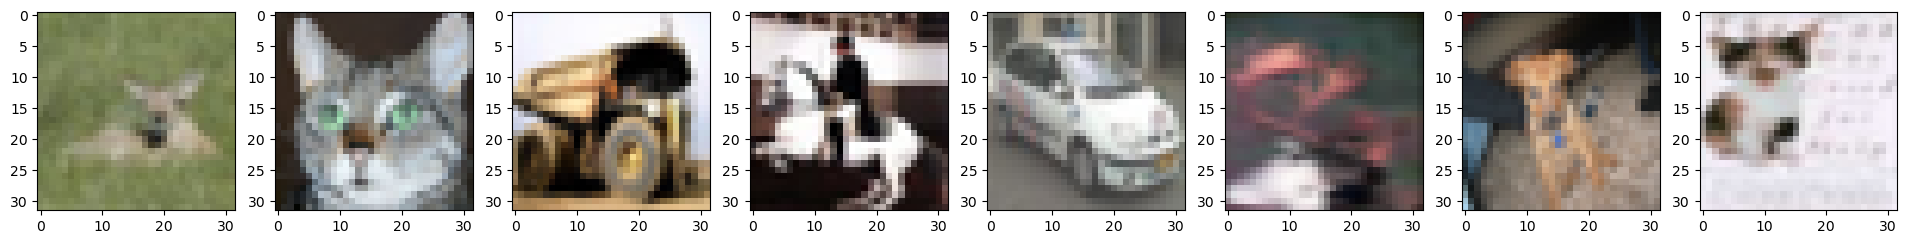

In [10]:
N_IMGS = 8
fig, ax = plt.subplots(1,N_IMGS)
fig.set_size_inches(3 * N_IMGS, 3)

ids = np.random.randint(low=0, high=len(train_dataset), size=N_IMGS)

for i, n in enumerate(ids):
    img = train_dataset[n][0].numpy().reshape(3,32,32).transpose(1, 2, 0)
    ax[i].imshow(img)
    #ax[i].set_title(f"Img #{n}  Label: {train_dataset[n][1]}")
    #ax[i].axis("off")
plt.show()

### Creating the model

In [11]:
class Model(nn.Module):
    """
    DESCRIPTION
    """
    def __init__(self, input_dim=784, hidden_dim=128, output_dim=10):
        """ Model initalizer """
        super().__init__()
        self.layers = nn.Sequential(
                nn.Linear(in_features=input_dim, out_features=hidden_dim),
                nn.ReLU(),
                nn.Linear(in_features=hidden_dim, out_features=output_dim)
            )
        
    def forward(self, x):
        """ Forward pass through the model"""
        assert len(x.shape) == 2, f"ERROR! Shape of input must be 2D (b_size, dim)"
        pred = self.layers(x)
        return pred
    
def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

### Training the model

In [12]:
from tqdm import tqdm

In [13]:
NUM_EPOCHS = int(config["NUM_EPOCHS"])
LR = float(config["LR"])

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(input_dim=3072, hidden_dim=512, output_dim=10)
model = model.to(device)

In [15]:
criterion = nn.CrossEntropyLoss()  # Note, that this already includes a Softmax!
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

Training loop

In [16]:
# For saving models and checkpoints later
if(not os.path.exists("models")):
    os.makedirs("models")

In [42]:
train_loss_list = []
test_loss_list = []
test_accuracy_list = []
train_accuracy_list = []
# Initialize lists to store gradient information
gradients = []
gradient_norms = []
gradient_max_values = []
gradient_min_values = []
best_loss = 100
for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm(trainloader, total=len(trainloader))
    for i, (imgs, labels) in enumerate(progress_bar):

        '''
        # Calculate test loss, accuracy for currently trained model
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data in testloader:
                images_test, labels_test = data
                # using GPU for inference
                images_test, labels_test = images_test.to(device), labels_test.to(device)
                # Flatten images
                flattened_images_test = images_test.flatten(start_dim=1)
                # calculate model outputs
                outputs_test = model(flattened_images_test)
                # calculate test loss
                loss = criterion(outputs_test, labels_test)
                test_loss += loss.item()
                # derive model predictions from out outputs
                predicted = torch.argmax(outputs_test, dim = -1)
                # calculate accuracy
                total += labels_test.size(0)
                correct += (predicted == labels_test).sum().item()

            test_loss /= len(testloader)
            accuracy = 100 * correct / total
            
        test_loss_list.append(test_loss)
        test_accuracy_list.append(accuracy)
        '''
        # Turn model back to training mode
        model.train()

        # using GPU
        imgs, labels = imgs.to(device), labels.to(device)
    
        # forward pass
        flattened_imgs = imgs.flatten(start_dim=1)
        preds = model(flattened_imgs)

        # calculate accuracy
        with torch.no_grad():
            predicted = preds.argmax(dim=-1)
            correct = (predicted == labels).sum().item()
            accuracy = correct/labels.shape[0]

        train_accuracy_list.append(accuracy)

        # computing error
        loss = criterion(preds, labels)
        train_loss_list.append(loss.item())


        # Potentially prevent overfitting
        if loss < best_loss:
            best_loss = loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, f"models/checkpoint_epoch_{epoch}.pth")
        #saving the best checkpoint


        # removing accumulated gradients
        optimizer.zero_grad()
    
        # backprogating error to compute gradients
        loss.backward()
    
        # updating parameters
        optimizer.step()

        '''In the following we calculate gradient information!'''
        
        # Calculate gradient information
        for name, param in model.named_parameters():
            # Tracking the matrices led to oom errors
            if name in ['layers.0.bias']:
                gradients.append(param.grad)
                gradient_norms.append(torch.norm(param.grad).item())
                gradient_max_values.append(param.grad.max().item())
                gradient_min_values.append(param.grad.min().item())

        '''Stop calculating gradient inforamtion'''
    
        if(i % 10 == 0 or i == len(trainloader) - 1):
            progress_bar.set_description(f"Epoch {epoch + 1} Iter {i + 1}: loss {loss.item():.5f}. ")

Epoch 10 Iter 782: loss 1.01178. : 100%|██████████| 782/782 [00:03<00:00, 260.50it/s]


evaluating the model

In [25]:
n_correct = 0
with torch.no_grad():
    progress_bar = tqdm(enumerate(testloader), total=len(testloader))
    for i, (imgs, labels) in progress_bar:
        #everything needs to be on the same device
        imgs = imgs.to(device)
        labels = labels.to(device)

        # forward pass
        flattened_imgs = imgs.flatten(start_dim=1)
        preds = model(flattened_imgs)

        pred_labels = torch.argmax(preds, dim=-1)
        cur_correct = len(torch.where(pred_labels == labels)[0])
        n_correct = n_correct + cur_correct


accuracy = n_correct / len(test_dataset) * 100
print(f"Test accuracy: {round(accuracy,2)}%")

  9%|▉         | 14/157 [00:00<00:01, 138.13it/s]

100%|██████████| 157/157 [00:00<00:00, 235.30it/s]

Test accuracy: 52.2%


# Evaluation without hyperparameter optimization
Here we achieved an accuracy of 48.55%. Considering we are working with 10 classes, this is still a lot better than random. Nevertheless, we hope that we can optimize the results even further with the hyperparameter optimization

### Visualizing the results

# Visualize the confusion matrix

In [26]:
y_true = None
y_pred = None

for imgs, labels in testloader:

    #everything needs to be on the same device
    imgs = imgs.to(device)
    labels = labels.to(device)

    # forward pass
    flattened_imgs = imgs.flatten(start_dim=1)
    preds = model(flattened_imgs)
    pred_labels = torch.argmax(preds, dim=-1)


    # collect predictions and labels into one array (mainly for the confusion matrix)
    if y_true is None:
        y_true = labels.clone()
    else:
        y_true = torch.cat((y_true, labels), dim = 0)

    if y_pred is None:
        y_pred = pred_labels
    else:
        y_pred = torch.cat((y_pred, pred_labels), dim = 0)

<Axes: >

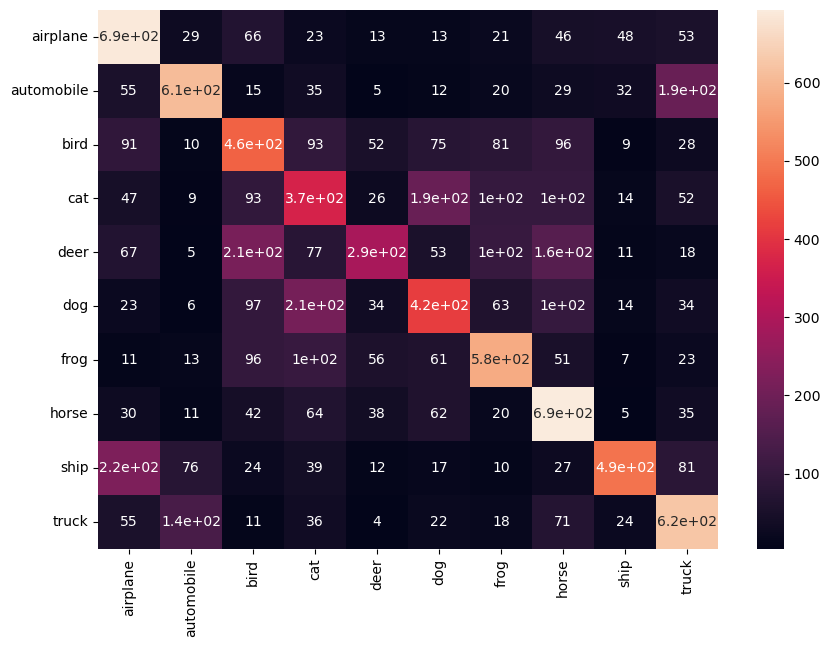

In [30]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns


matrix = confusion_matrix(y_true.cpu(), y_pred.cpu())

df_cm = pd.DataFrame(matrix, index = [i for i in ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']], columns = [i for i in ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']])

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

In [31]:
def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f

In [45]:
# Note: CELL NEEDS TO BE DELETED
# Only because I do not have enough performance right now
test_loss_list = [x + 0.5 for x in train_loss_list]

In [46]:
def plot_loss(loss_list = train_loss_list, t_loss_list = test_loss_list):
    # Plot train and test loss
    plt.style.use('seaborn')
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(18,5)

    smooth_loss = smooth(loss_list, 31)
    smooth_test_loss = smooth(test_loss_list, 31)

    ax[0].plot(loss_list, c="blue", label="Training Loss", linewidth=3, alpha=0.5)
    ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3)
    ax[0].plot(t_loss_list, c="green", label="Test Loss", linewidth=3, alpha=0.5)
    ax[0].plot(smooth_test_loss, c="yellow", label="Smoothed Test Loss", linewidth=3)


    ax[0].legend(loc="best")
    ax[0].set_xlabel("Iteration")
    ax[0].set_ylabel("CE Loss")
    ax[0].set_title("Training Progress (linearscale)")

    ax[1].plot(loss_list, c="blue", label="Training Loss", linewidth=3, alpha=0.5)
    ax[1].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3)
    ax[1].plot(t_loss_list, c="green", label="Test Loss", linewidth=3, alpha=0.5)
    ax[1].plot(smooth_test_loss, c="yellow", label="Smoothed Test Loss", linewidth=3)
    ax[1].legend(loc="best")
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("CE Loss")
    ax[1].set_yscale("log")
    ax[1].set_title("Training Progress (logscale)")

    plt.show()

In [47]:
def plot_accuracy(test_accuracy, train_accuracy):
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(18,5)

    smooth_test_accuracy = smooth(test_accuracy, 31)
    smooth_train_accuracy = smooth(train_accuracy, 31)

    ax[0].plot(test_accuracy, c="blue", label="Testing Accuracy", linewidth=3, alpha=0.5)
    ax[0].plot(smooth_test_accuracy, c="red", label="Smoothed Testing Accuracy", linewidth=3, alpha=0.5)



    ax[0].legend(loc="best")
    ax[0].set_xlabel("Iteration")
    ax[0].set_ylabel("Testing Accuracy")
    ax[0].set_title("Testing Accuracy Change")


    ax[1].plot(train_accuracy, c="blue", label="Training Accuracy", linewidth=3, alpha=0.5)
    ax[1].plot(smooth_train_accuracy, c="red", label="Smoothed Training Accuracy", linewidth=3, alpha=0.5)

    ax[1].legend(loc="best")
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("Training Accuracy")
    ax[1].set_title("Training Accuracy Change")

    plt.show()

In [48]:
def plot_gradients(norms, max_values, min_values):
    plt.style.use('seaborn')
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(18, 5)

    ax[0].plot(norms, c="blue", label="Gradient Norms", linewidth=3, alpha=0.5)
    ax[0].legend(loc="best")
    ax[0].set_xlabel("Iteration")
    ax[0].set_ylabel("Gradient Norms")
    ax[0].set_title("Gradient Norms Change")

    ax[1].plot(max_values, c="red", label="Max Gradient Values", linewidth=3, alpha=0.5)
    ax[1].legend(loc="best")
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("Max Gradient Values")
    ax[1].set_title("Max Gradient Values Change")

    ax[2].plot(min_values, c="green", label="Min Gradient Values", linewidth=3, alpha=0.5)
    ax[2].legend(loc="best")
    ax[2].set_xlabel("Iteration")
    ax[2].set_ylabel("Min Gradient Values")
    ax[2].set_title("Min Gradient Values Change")

    plt.show()


/tmp/ipykernel_761303/3956005713.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


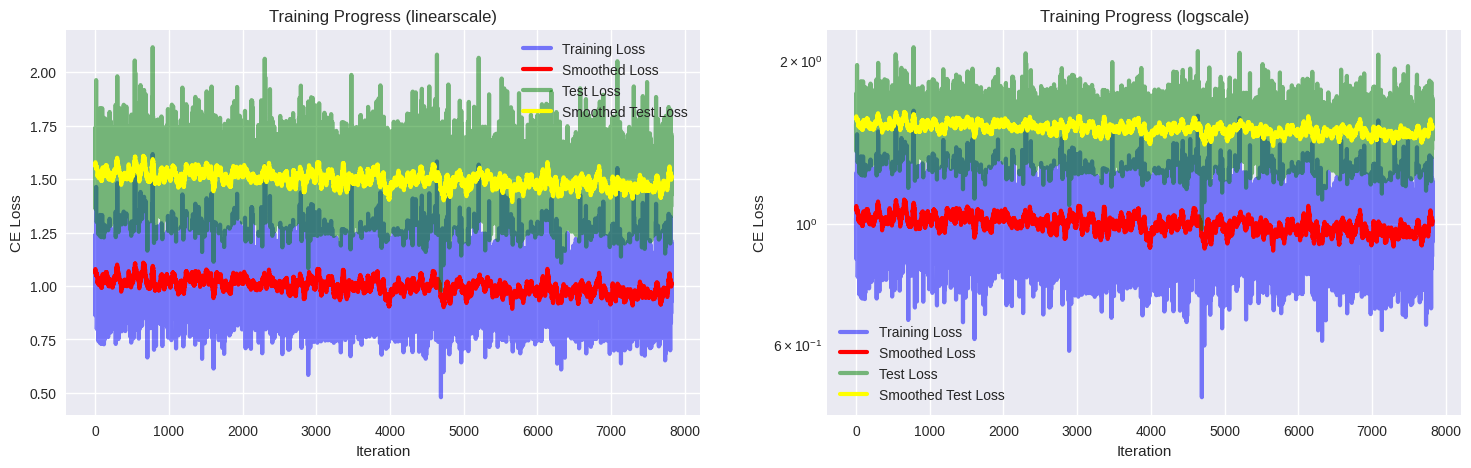

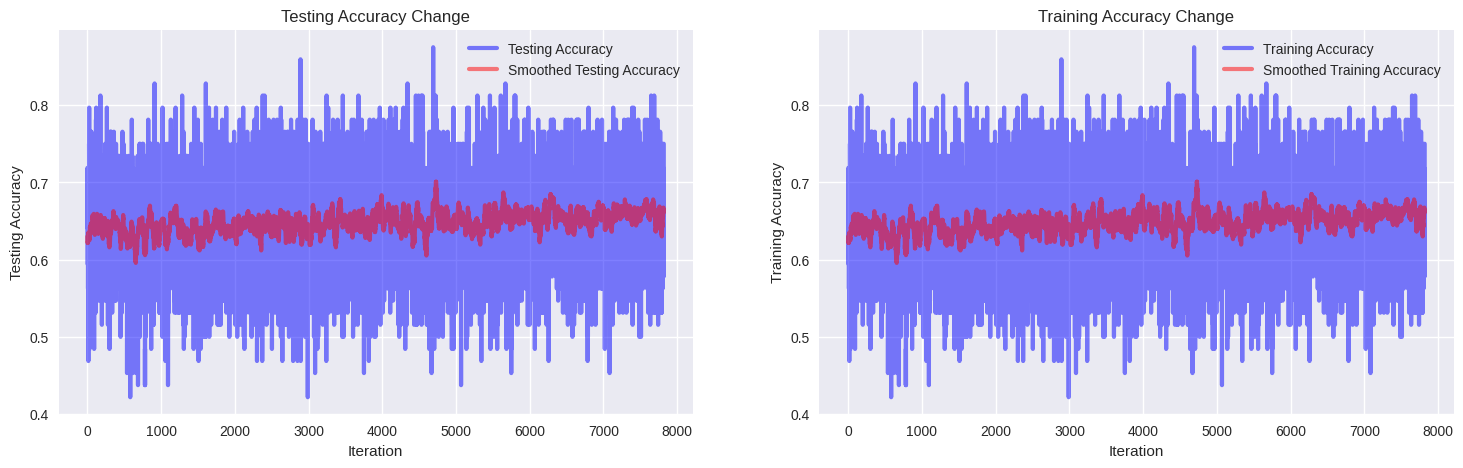

/tmp/ipykernel_761303/3494184149.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


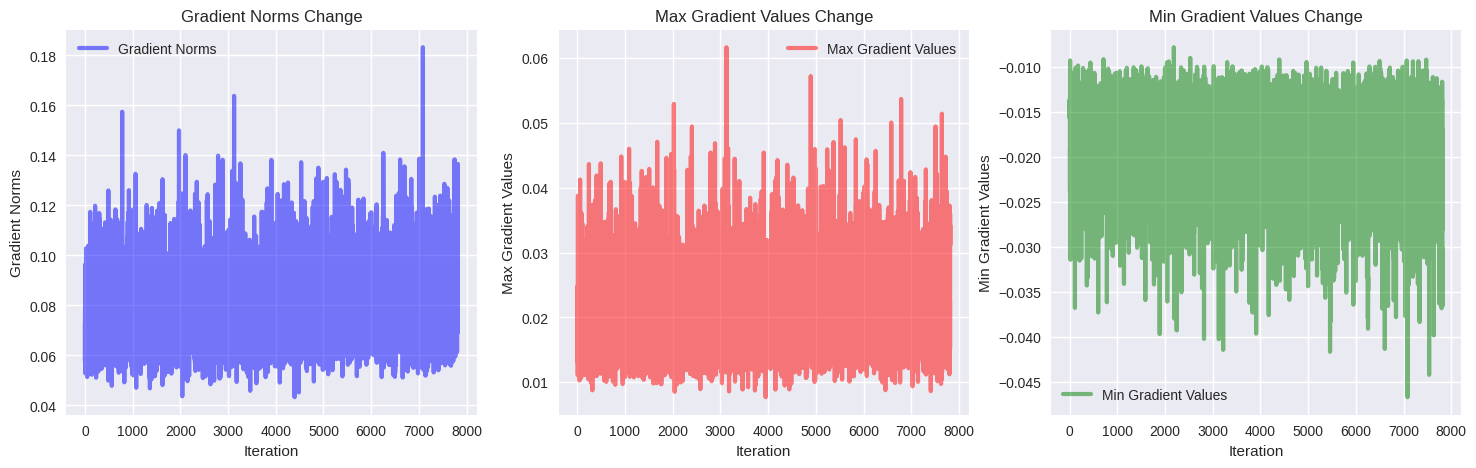

In [ ]:
plot_loss()
plot_accuracy(train_accuracy_list, train_accuracy_list)
plot_gradients(gradient_norms, gradient_max_values, gradient_min_values)

### Hyperparameter optimization using optuna

In [ ]:
import optuna
from optuna.trial import TrialState

We decided that the best course of action would be to add dropout rate to hyperparameters that we want to optimize in order to avoid overfitting

In [ ]:
def define_model(trial):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    n_layers = trial.suggest_int("n_layers", 0, 3)
    layers = []
    num_classes = 10
    input_dim = 32*32*3 #CIFAR10 image dims
    for i in range(n_layers):
        hidden_dim = trial.suggest_int("n_units_l{}".format(i), 512, 1024)
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
       # p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.5)
       # layers.append(nn.Dropout(p))
        input_dim = hidden_dim
    layers.append(nn.Linear(input_dim, num_classes))

    return nn.Sequential(*layers)

In [ ]:
#added for better visibility
criterion = nn.CrossEntropyLoss()  # Note, that this already includes a Softmax!
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

Objective function to be maximized (based on accuracy)

In [ ]:
def objective(trial):

    # Generate the model.
    model = define_model(trial).to(device)
    
    model.train()

    for epoch in range(NUM_EPOCHS):
        progress_bar = tqdm(trainloader, total=len(trainloader))
        for i, (imgs, labels) in enumerate(progress_bar):
            # comment these 2 lines if device=="cpu"
            labels = labels.to(device)
            imgs = imgs.to(device)
            # forward pass
            flattened_imgs = imgs.flatten(start_dim=1)
            preds = model(flattened_imgs)

            # computing error
            loss = criterion(preds, labels)

            # removing accumulated gradients
            optimizer.zero_grad()
        
            # backprogating error to compute gradients
            loss.backward()
        
            # updating parameters
            optimizer.step()

        #evaluating the model
        model.eval()
        n_correct = 0
        with torch.no_grad():
            progress_bar = tqdm(enumerate(testloader), total=len(testloader))
            for i, (imgs, labels) in progress_bar:
                #everything needs to be on the same device
                imgs = imgs.to(device)
                labels = labels.to(device)

                # forward pass
                flattened_imgs = imgs.flatten(start_dim=1)
                preds = model(flattened_imgs)

                pred_labels = torch.argmax(preds, dim=-1)
                cur_correct = len(torch.where(pred_labels == labels)[0])
                n_correct = n_correct + cur_correct

        accuracy = n_correct / len(test_dataset) * 100
            
        trial.report(accuracy, epoch)
        
        # prune some trials that are doomed to save time
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return accuracy #We could also maximize with respect to loss

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("{}: {}".format(key, value))

In [ ]:
#visualizing plots (we will discuss them later)
fig_1 = optuna.visualization.plot_rank(study)
fig_2 = optuna.visualization.plot_param_importances(study)
fig_3 = optuna.visualization.plot_contour(study)
fig_4 = optuna.visualization.plot_slice(study)

In [ ]:
fig_1.show()

In [ ]:
fig_2.show()

In [ ]:
fig_3.show()